In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib
matplotlib.style.use('seaborn')

from draftbot import Draft
from itertools import repeat

In [2]:
draft = Draft()
drafters = draft.draft()

In [3]:
def make_archytype_color_mapping(alpha):
    arch_color_mapping = {
        'W': [1, 0.8, 0.5, alpha],
        'U': [0.2, 0.2, 1, alpha],
        'B': [0.2, 0.2, 0.2, alpha],
        'R': [1, 0, 0, alpha],
        'G': [0, 0.8, 0, alpha]
    }
    return arch_color_mapping

rarity_color_mapping = {
    'common': [0.0, 0.0, 0.0],
    'uncommon': [192 / 255, 192 / 255, 192 / 255],
    'rare': [255 / 255, 215 / 255, 0],
    'mythic': [255 / 255, 140 / 255, 0],    
}

def make_archytype_colors(arch, alpha=1):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    return [arch_color_mapping[c] for c in arch]

In [4]:
def plot_alternating_color_line(ax, x, y, colors):
    x, y = insert_middpoints(x.astype(float)), insert_middpoints(y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segment_boundaries = insert_middpoints(np.arange(x.min(), x.max() + 1))
    n_bins = len(segment_boundaries) - 1
    cmap = ListedColormap((colors*n_bins)[:n_bins])
    norm = BoundaryNorm(segment_boundaries, cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)

def insert_middpoints(arr):
    midpoints = (arr[:-1] + arr[1:]) / 2
    return np.insert(arr, np.arange(1, len(arr)), midpoints)

In [5]:
def plot_color_identity_dot(ax, x, y, color_identity, s=100, alpha=1.0):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    colors = [arch_color_mapping[c] for c in color_identity]
    if len(colors) == 0:
        ax.scatter(x, y, c=['grey'], s=s, zorder=2)
    if len(colors) == 1:
        ax.scatter(x, y, c=[colors[0]], s=s, zorder=2)
    if len(colors) >= 2:
        plot_multi_color_dot(ax, x, y, colors)

def plot_multi_color_dot(ax, x, y, colors, s=100):
    angles = list(np.linspace(start=0, stop=2*np.pi, num=(len(colors) + 1)))
    begin_angles = angles[:-1]
    end_angles = angles[1:]
    for angle, end_angle, color in zip(begin_angles, end_angles, colors):
        xs = [0] + np.sin(np.linspace(angle, end_angle, 25)).tolist()
        ys = [0] + np.cos(np.linspace(angle, end_angle, 25)).tolist()
        xy = np.column_stack([xs, ys])
        ax.scatter(x, y, marker=xy, s=s, facecolor=color, zorder=2)

In [6]:
def plot_drafter_history(ax, drafter):
    history_df = pd.DataFrame(drafter._archytype_preferences_history)
    history_df = pd.DataFrame(
        np.exp(history_df).values 
        / np.exp(history_df).sum(axis=1).values.reshape(-1, 1),
        columns=history_df.columns)
    winning_archytype = history_df.iloc[-1, :].idxmax()
    winning_history = history_df.loc[:, winning_archytype]

    


    colors = make_archytype_colors(winning_archytype, alpha=1.0)
    plot_alternating_color_line(
        ax, 
        winning_history.index.values, 
        winning_history.values, 
        colors)
    
    for arch in set(history_df.columns) - set([winning_archytype]):
        arch_history = history_df.loc[:, arch]
        colors = make_archytype_colors(arch, alpha=0.2)
        plot_alternating_color_line(
            ax,
            arch_history.index.values,
            arch_history.values, colors)
    
    card_rarities = [card['rarity'] for card in drafter.cards]
    card_colors = [card['colorIdentity'] for card in drafter.cards]
    dot_data = zip(
        card_colors, 
        card_rarities, 
        winning_history.index.values + 1,
        winning_history.values[1:])
    for pick_num, (color_pair, rarity, x, y) in enumerate(dot_data):
        ax.scatter(x, y, s=170, c=[rarity_color_mapping[rarity]])
        plot_color_identity_dot(ax, x, y, color_pair)
        if pick_num % 14 == 1:
            ax.axvline(pick_num, linestyle='--', alpha=0.5)

    ax.set_xlim(-1, 43)
    ax.set_ylim(-0.1, 1.1)

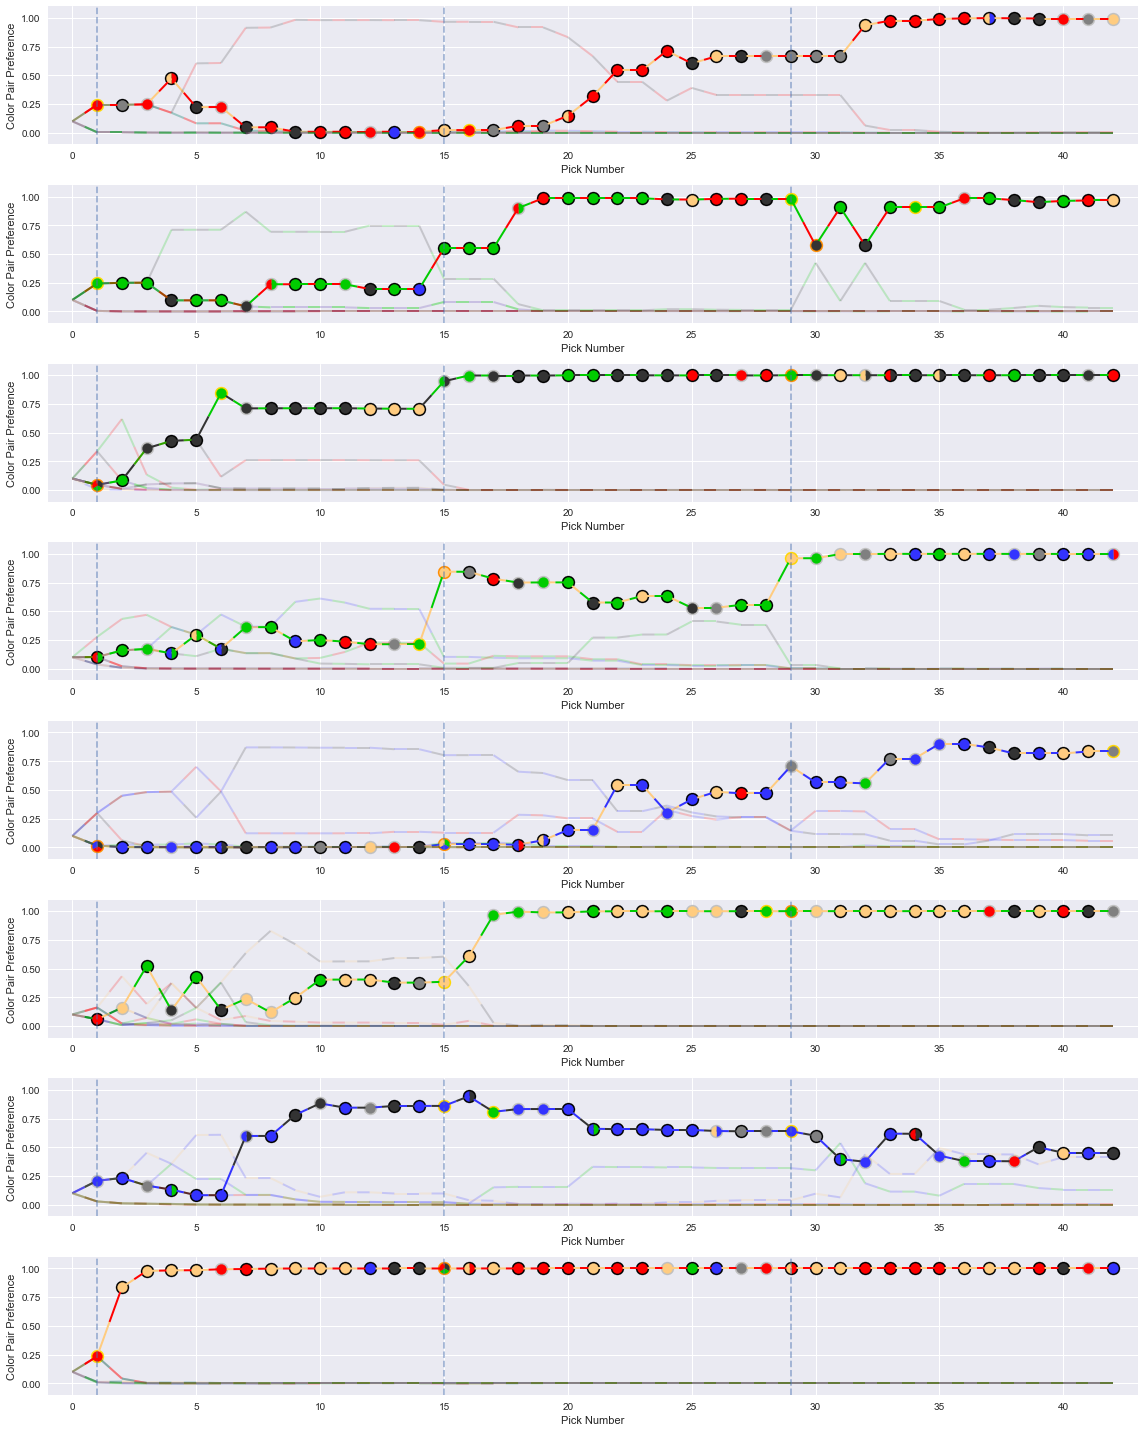

In [7]:
fig, axs = plt.subplots(8, 1, figsize=(16, 20))

for ax, drafter in zip(axs, drafters):
    plot_drafter_history(ax, drafter)
    ax.set_xlabel("Pick Number")
    ax.set_ylabel("Color Pair Preference")
fig.tight_layout()

In [8]:
for i, card in enumerate(drafters[0].cards, start=1):
    print(i, ': ', card['name'])

1 :  Lathliss, Dragon Queen
2 :  Explosive Apparatus
3 :  Fiery Finish
4 :  Stone Quarry
5 :  Lich's Caress
6 :  Fiery Finish
7 :  Lich's Caress
8 :  Catalyst Elemental
9 :  Skeleton Archer
10 :  Sure Strike
11 :  Havoc Devils
12 :  Lightning Mare
13 :  Uncomfortable Chill
14 :  Apex of Power
15 :  Luminous Bonds
16 :  Dismissive Pyromancer
17 :  Manalith
18 :  Viashino Pyromancer
19 :  Manalith
20 :  Stone Quarry
21 :  Act of Treason
22 :  Goblin Instigator
23 :  Hostile Minotaur
24 :  Act of Treason
25 :  Hired Blade
26 :  Dwarven Priest
27 :  Mind Rot
28 :  Rogue's Gloves
29 :  Skyscanner
30 :  Explosive Apparatus
31 :  Manalith
32 :  Pegasus Courser
33 :  Trumpet Blast
34 :  Radiating Lightning
35 :  Viashino Pyromancer
36 :  Lava Axe
37 :  Meandering River
38 :  Grasping Scoundrel
39 :  Hired Blade
40 :  Inferno Hellion
41 :  Rogue's Gloves
42 :  Aegis of the Heavens


In [9]:
def convert_to_discount_factor(pick_num):
    return 1 / (1 + np.exp((pick_num - 10)))

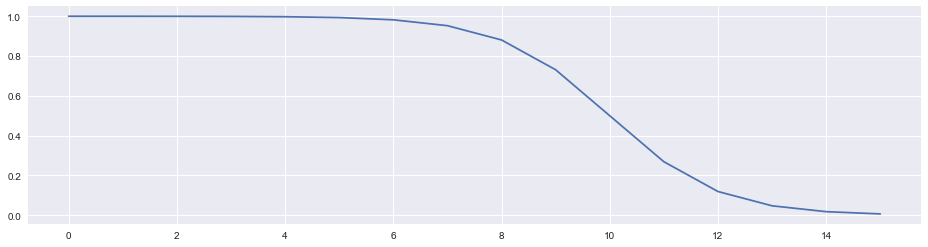

In [10]:
fix, ax = plt.subplots(figsize=(16, 4))

t = np.arange(0, 16)
ax.plot(t, convert_to_discount_factor(t))